<a href="https://colab.research.google.com/github/harshadindigal/Introduction_to_Porfoliio_Construction_and_Analysis_with_Python/blob/master/Lab_Risk_Adjusted_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: Get the Data

In [32]:
import requests 
import pandas as pd
import time 
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np

In [4]:
def get_price_data(ticker, periodType, frequencyType, frequency, needExtendedHoursData):
  endpoint = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(ticker)
  payload = {'apikey': 'LTYN4O0OYOCVQOJANYFQUQUPZGAXNLGA',
            'periodType':periodType,
            'frequencyType': frequencyType,
            'frequency':frequency,
            'period':'1',
            'needExtendedHoursData':needExtendedHoursData}
  content = requests.get(url = endpoint, params = payload)
  data = content.json()
  test_data = pd.DataFrame.from_dict(data['candles'][0], orient='index')
  test_data_1 = test_data.T
  
  for items in data['candles']:
    temp = pd.DataFrame.from_dict(items, orient='index')
    temp_1 = temp.T
    test_data_1 = test_data_1.append(temp_1, ignore_index=True)
  return test_data_1


In [5]:
gold = get_price_data("GOLD",'ytd','daily','1','false')
silver = get_price_data('SLV','ytd','daily','1','false')
spy = get_price_data('SPY','ytd','daily','1','false')
tlt = get_price_data('TLT','ytd','daily','1','false')
agg = get_price_data('AGG','ytd','daily','1','false')
volatility = get_price_data('UVXY','ytd','daily','1','false')

pd.set_option('float_format', '{:f}'.format)

In [6]:
list_of_var = [gold,silver,spy,tlt,agg,volatility]
for var in list_of_var:
  var['datetime'] = pd.to_datetime(var['datetime'],unit='ms')

In [7]:
variables = ["gold","silver","spy","tlt","agg","uvxy"]
for x in range(len(variables)):
  list_of_var[x]["symbol"] = variables[x]
finish = pd.DataFrame()
for x in range(len(variables)):
  temp = list_of_var[x][['open','datetime',"symbol"]].iloc[1:]
  finish = finish.append(temp)
full_data = finish.pivot(index ='datetime', columns ='symbol')   
print(full_data)

                          open            ...                     
symbol                     agg      gold  ...        tlt      uvxy
datetime                                  ...                     
2020-01-02 06:00:00 112.680000 18.710000  ... 136.790000 12.360000
2020-01-03 06:00:00 112.890000 18.930000  ... 138.270000 13.550000
2020-01-06 06:00:00 113.130000 18.980000  ... 139.690000 13.650000
2020-01-07 06:00:00 112.920000 18.390000  ... 138.220000 12.910000
2020-01-08 06:00:00 112.850000 18.510000  ... 137.930000 12.550000
...                        ...       ...  ...        ...       ...
2020-07-21 05:00:00 119.100000 28.760000  ... 167.300000 24.930000
2020-07-22 05:00:00 119.220000 28.650000  ... 168.260000 26.570000
2020-07-23 05:00:00 119.350000 28.510000  ... 168.920000 25.480000
2020-07-24 05:00:00 119.260000 28.120000  ... 169.010000 28.340000
2020-07-27 05:00:00 119.400000 29.500000  ... 170.250000 26.670000

[143 rows x 6 columns]


First order principles breakdown of Standard Devation

In [9]:
full_data.pct_change().std()

      symbol
open  agg      0.006106
      gold     0.046834
      silver   0.027175
      spy      0.022407
      tlt      0.016610
      uvxy     0.123508
dtype: float64

In [12]:
deviations = full_data.pct_change() - full_data.pct_change().mean()
squared_deviations = deviations**2
variance = squared_deviations.mean()
volatility = np.sqrt(variance)
volatility

      symbol
open  agg      0.006085
      gold     0.046669
      silver   0.027079
      spy      0.022328
      tlt      0.016551
      uvxy     0.123072
dtype: float64

Why did a difference occur? The concept of **sample** std devation vs **population** std. devation, when calculating the mean of the differences of the observed values from the mean, the .std() method uses N-1 as the denominator, whereas we used N in the first order principles version, which represents a population paramter vs. sample statistic

In [15]:
number_of_obs = full_data.pct_change().shape[0]
variance2 = squared_deviations.sum()/(number_of_obs-2)
#used 2 instead of 1 because 1st row is just Nans
volatility2 = np.sqrt(variance2)
volatility2 

      symbol
open  agg      0.006106
      gold     0.046834
      silver   0.027175
      spy      0.022407
      tlt      0.016610
      uvxy     0.123508
dtype: float64

Get data from Fama-French research website. The following dataset includes monthly returns for stocks grouped by various market cap communities from 1929 to 2018

In [23]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [117]:
data = pd.read_csv("/content/gdrive/My Drive/Finance Coursera/Portfolios_Formed_on_ME_monthly_EW.csv",header=0, index_col = 0, parse_dates = True, na_values = -99.99)

In [118]:
data.head()

,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
192607,nan,-0.430000,1.520000,2.680000,-0.570000,0.590000,1.600000,1.470000,3.330000,-1.450000,0.290000,-0.150000,1.330000,1.240000,1.980000,1.550000,1.380000,3.380000,3.290000
192608,nan,3.900000,3.040000,2.090000,3.840000,3.590000,3.710000,1.610000,2.330000,5.120000,2.590000,4.030000,3.150000,2.720000,4.720000,1.600000,1.630000,0.980000,3.700000
192609,nan,-1.080000,-0.540000,0.160000,-0.480000,-1.400000,0.000000,-0.500000,-0.090000,0.930000,-1.870000,-2.270000,-0.530000,0.070000,-0.070000,-1.640000,0.640000,-0.860000,0.670000
192610,nan,-3.320000,-3.520000,-3.060000,-3.290000,-4.100000,-2.890000,-3.360000,-2.950000,-4.840000,-1.770000,-3.360000,-4.830000,-2.980000,-2.800000,-3.450000,-3.270000,-3.470000,-2.430000
192611,nan,-0.460000,3.820000,3.090000,-0.550000,2.180000,3.410000,3.390000,3.160000,-0.780000,-0.320000,-0.290000,4.650000,3.240000,3.570000,3.820000,2.950000,3.610000,2.700000


In [119]:
data.shape

(1110, 19)

In [120]:
columns = ['Lo 20', 'Qnt 2', 'Qnt 3', 'Qnt 4','Hi 20']
data = data[columns]
data.head()

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20
192607,-0.570000,0.590000,1.600000,1.470000,3.330000
192608,3.840000,3.590000,3.710000,1.610000,2.330000
192609,-0.480000,-1.400000,0.000000,-0.500000,-0.090000
192610,-3.290000,-4.100000,-2.890000,-3.360000,-2.950000
192611,-0.550000,2.180000,3.410000,3.390000,3.160000


In [121]:
data = data/100
data.head()

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20
192607,-0.005700,0.005900,0.016000,0.014700,0.033300
192608,0.038400,0.035900,0.037100,0.016100,0.023300
192609,-0.004800,-0.014000,0.000000,-0.005000,-0.000900
192610,-0.032900,-0.041000,-0.028900,-0.033600,-0.029500
192611,-0.005500,0.021800,0.034100,0.033900,0.031600


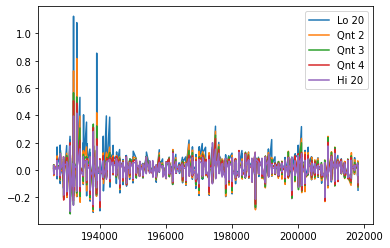

In [122]:
data.plot.line()
#data.columns = ["SmallCap","LargeCap"]

In [123]:
data.std()

Lo 20   0.097197
Qnt 2   0.079290
Qnt 3   0.070483
Qnt 4   0.063937
Hi 20   0.056325
dtype: float64

In [124]:
#Annualized Volatility
annualized_vol = data.std()*np.sqrt(12)
annualized_vol

Lo 20   0.336701
Qnt 2   0.274667
Qnt 3   0.244160
Qnt 4   0.221486
Hi 20   0.195116
dtype: float64

In [125]:
#Compounded Monthly Growth Rate
n_months = data.shape[0]
return_per_month = (data +1).prod()**(1/n_months) -1 
return_per_month

Lo 20   0.011860
Qnt 2   0.009469
Qnt 3   0.009159
Qnt 4   0.008696
Hi 20   0.007859
dtype: float64

In [126]:
#Annualized Return 
Annual_Return0 = (return_per_month + 1)**(12) -1
Annual_Return = ((data +1).prod()**(12/n_months))-1
Annual_Return
#Annual_Return0

Lo 20   0.151977
Qnt 2   0.119742
Qnt 3   0.115613
Qnt 4   0.109488
Hi 20   0.098490
dtype: float64

In [127]:
#Basic Return/Risk Ration
Annual_Return/annualized_vol

Lo 20   0.451370
Qnt 2   0.435953
Qnt 3   0.473514
Qnt 4   0.494332
Hi 20   0.504778
dtype: float64

In [128]:
#Sharpe Reation 
riskfree_rate = 0.03 
excess_return = Annual_Return - riskfree_rate
Sharpe_Ratio = excess_return/annualized_vol
Sharpe_Ratio

Lo 20   0.362271
Qnt 2   0.326730
Qnt 3   0.350643
Qnt 4   0.358883
Hi 20   0.351023
dtype: float64



```
Homework for Lab: Try out same analysis on 5 quintiles```

